# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [131]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [132]:
# Load in the general demographics data.
azdias_raw = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info_raw = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [95]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Number of azdias rows: " + str(len(azdias_raw)))
print("Number of azdias columns: " + str(len(azdias_raw.columns)))

print("Number of azdias rows: " + str(len(feat_info_raw)))
print("Number of feat_info columns: " + str(len(feat_info_raw.columns)))

Number of azdias rows: 891221
Number of azdias columns: 85
Number of azdias rows: 85
Number of feat_info columns: 4


In [20]:
azdias_raw.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [21]:
feat_info_raw.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [133]:
# Identify missing or unknown data values and convert them to NaNs.
#feat_info.columns
feat_info_raw['missing_unk_list'] = feat_info_raw['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

In [134]:
def missing_to_nan(df):
    for i, series in enumerate(df.iteritems()):
        missing_unknown = feat_info_raw['missing_unk_list'][i]
        col = series[0]
        if missing_unknown != ['']:
            queue = []
            for j in missing_unknown:
                if j in ['X','XX']:
                    queue.append(j)
                else:
                    queue.append(int(j))
            df[col] = df[col].replace(queue,np.nan)
    return df

In [135]:
azdias_nan = missing_to_nan(azdias_raw)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

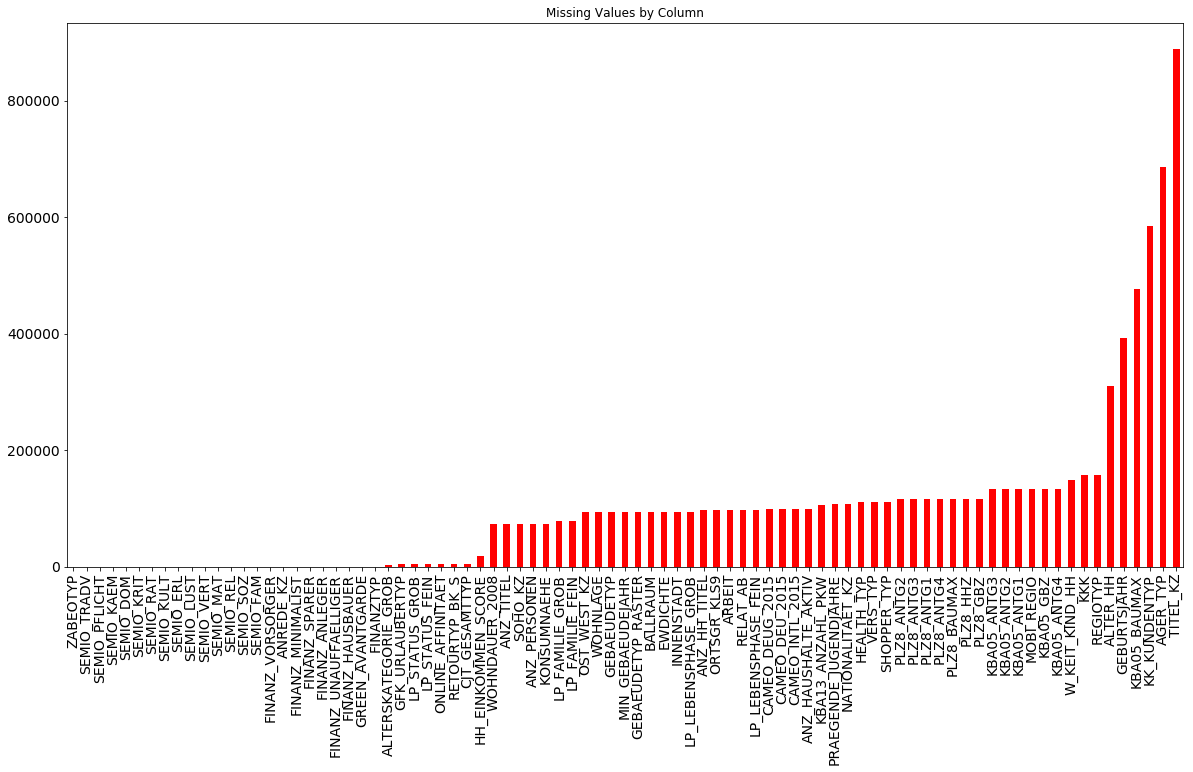

In [136]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_nan.isnull().sum().sort_values().plot.bar(figsize = (20,10), 
                                             fontsize = 14, 
                                             color = 'red', 
                                             title = 'Missing Values by Column')


In [137]:
# Investigate patterns in the amount of missing data in each column.
#categorize features based on data dict
category_list = []

feat_person = ['AGER_TYP','ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 
            'FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','GEBURTSJAHR','GFK_URLAUBERTYP','GREEN_AVANTGARDE',
            'HEALTH_TYP','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
            'LP_STATUS_GROB','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','RETOURTYP_BK_S','SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST','SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT', 'SEMIO_TRADV',
            'SHOPPER_TYP','SOHO_KZ','TITEL_KZ','VERS_TYP','ZABEOTYP',]
category_list.append(feat_person)

feat_household = ['ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 
                  'WOHNDAUER_2008']
category_list.append(feat_household)

feat_building = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 
                 'WOHNLAGE']
category_list.append(feat_building)

feat_rr4 = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
category_list.append(feat_rr4)

feat_rr3 = ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX']
category_list.append(feat_rr3)

feat_postcode = ['BALLRAUM', 'EWDICHTE', 'INNENSTADT']
category_list.append(feat_postcode)

feat_region = ['GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', ]
category_list.append(feat_region)

feat_macro = ['KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
category_list.append(feat_macro)

feat_community = ['ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
category_list.append(feat_community)

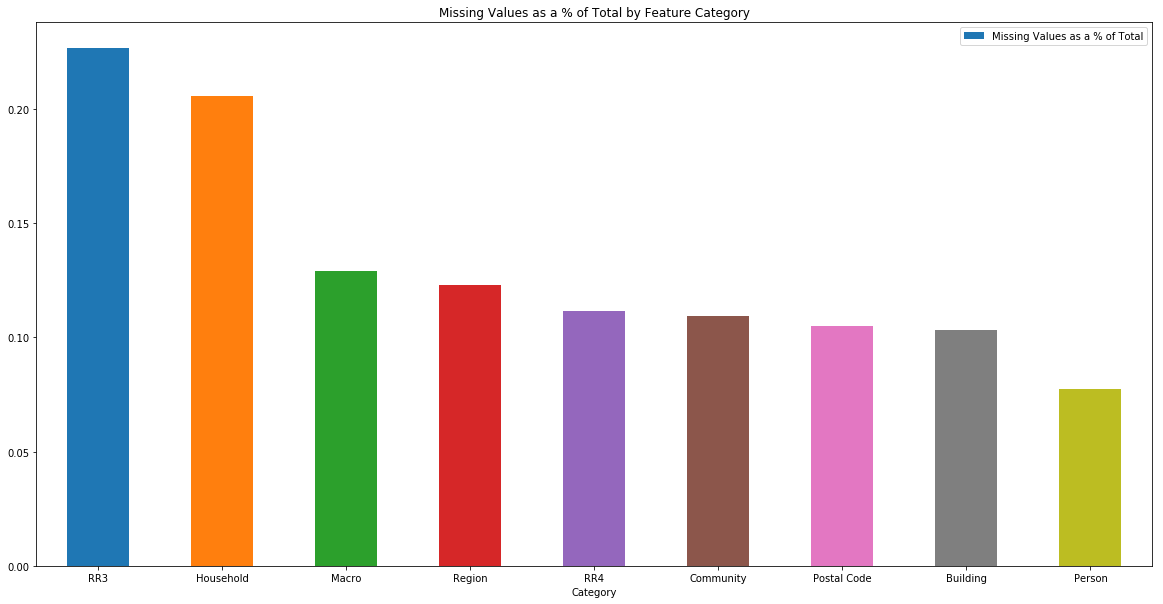

In [138]:
"""
Assessing which categories have the highest percentage of missing values for all datapoints in the category:
"""
x = ['Person', 'Household', 'Building', 'RR4', 'RR3', 'Postal Code', 'Region', 'Macro', 'Community']
y = []
for ls in category_list:
    y.append(azdias_nan[ls].isnull().sum().sum() / (len(ls) * len(azdias_nan)))

df_missing_by_cat = pd.DataFrame({
    'Category':x,
    'Missing Values as a % of Total':y
})    


df_missing_by_cat.sort_values(
                                by = 'Missing Values as a % of Total', 
                                ascending = False).plot.bar(
                                                            figsize = (20,10),
                                                            x='Category', 
                                                            y='Missing Values as a % of Total', 
                                                            rot=0,
                                                            title = 'Missing Values as a % of Total by Feature Category')

In [139]:
cols = []
percent_missing = []

for col in azdias_nan.columns:
    cols.append(col)
    missing = azdias_nan[col].isnull().sum() / len(azdias_nan[col])
    percent_missing.append(missing)
    
df_perc_missing = pd.DataFrame({
    'Column': cols,
    'Percent Missing': percent_missing
}).sort_values(by = 'Percent Missing', ascending = False)

df_perc_missing

,Column,Percent Missing
40,TITEL_KZ,0.997576
0,AGER_TYP,0.769554
47,KK_KUNDENTYP,0.655967
64,KBA05_BAUMAX,0.534687
11,GEBURTSJAHR,0.440203
43,ALTER_HH,0.348137
70,KKK,0.177357
73,REGIOTYP,0.177357
48,W_KEIT_KIND_HH,0.166051
60,KBA05_ANTG1,0.149597


In [140]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Define outlier as missing data > 1.5 * IQR of % missing values per column
quantile_25 = df_perc_missing['Percent Missing'].quantile(.25)
quantile_75 = df_perc_missing['Percent Missing'].quantile(.75)
iqr =  quantile_75 - quantile_25

feat_remove = list(df_perc_missing[df_perc_missing['Percent Missing'] > 1.5 * iqr]['Column'])
feat_remove

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [141]:
azdias_droppedcols = azdias_nan.drop(feat_remove, axis = 1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

I elected to remove the six columns where percentage of missing data exceeded 1.5x the interquartile range of missing data percentages among the columns (https://en.wikipedia.org/wiki/Interquartile_range).  

I noticed that 'AGER_TYP', 'GEBURTSJAHR', and 'TITEL_KZ' are person-level features. 

'ALTER_HH' and 'KK_KUNDENTYP' are Household level features.  

'KBA05_BAUMAX' is a rr3 feature.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [142]:
# How much data is missing in each row of the dataset?
azdias_droppedcols.isnull().sum(axis = 1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

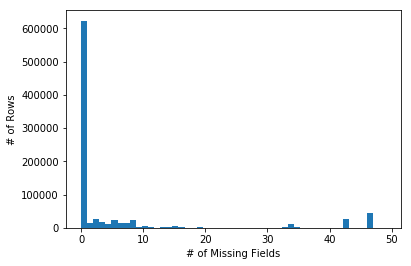

In [143]:
#Show distribution of # missing fields:
plt.hist(azdias_droppedcols.isnull().sum(axis = 1), bins = 50)
plt.xlabel('# of Missing Fields')
plt.ylabel('# of Rows')
plt.show()

In [144]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missingrows = azdias_droppedcols.isnull().sum(axis = 1)
missingrows_q25 = missingrows.quantile(0.25)
missingrows_q75 = missingrows.quantile(0.75)

missingrows_iqr = missingrows_q75 - missingrows_q25

In [145]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_droppedcols['Number of Missing Fields'] = azdias_droppedcols.isnull().sum(axis = 1)

df_keeprows = azdias_droppedcols[azdias_droppedcols['Number of Missing Fields'] <= 1.5* missingrows_iqr]

df_droprows = azdias_droppedcols[azdias_droppedcols['Number of Missing Fields'] > 1.5* missingrows_iqr]

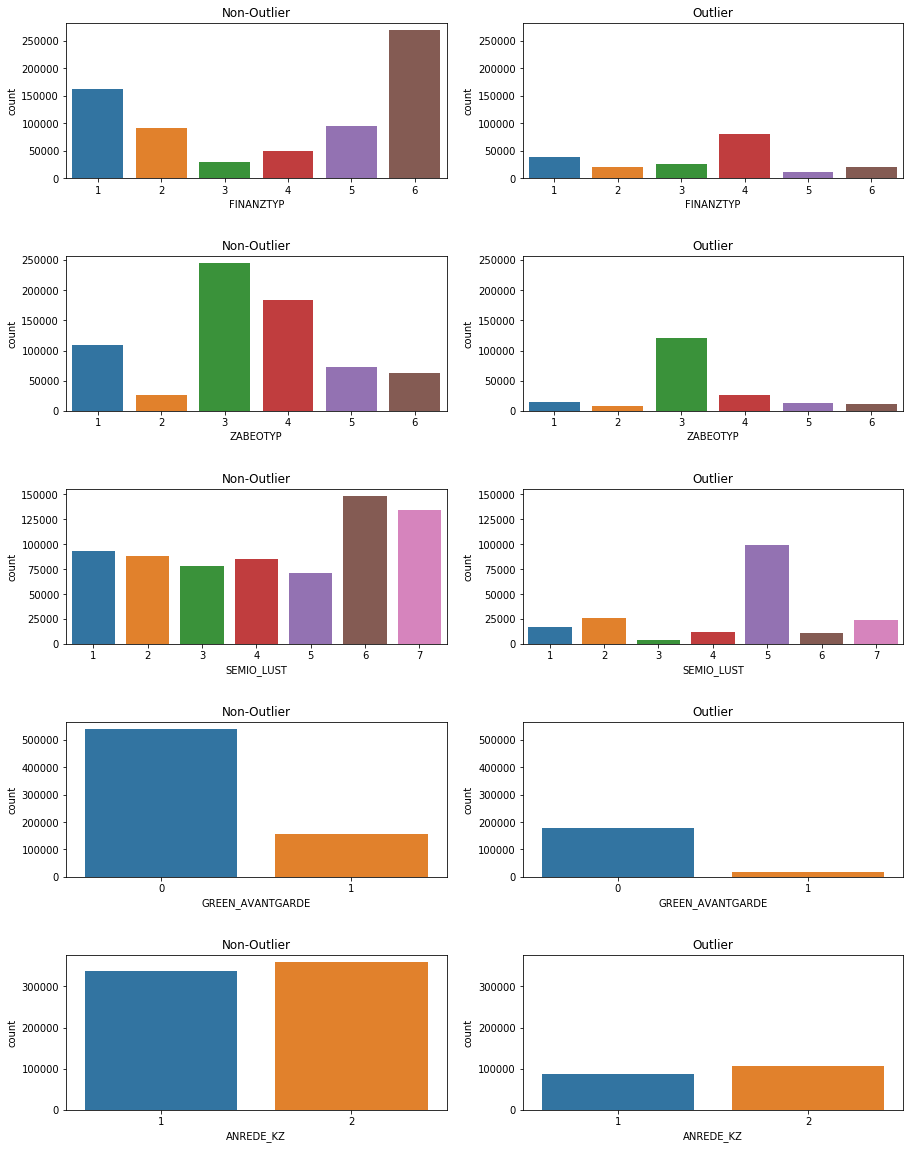

In [146]:
#Compare value distributions for some columns with complete data (no missing values)
plt.figure(figsize=(15, 20))
#space them out a bit
plt.subplots_adjust(hspace=0.5)
"""
8	FINANZ_UNAUFFAELLIGER	0.000000
10	FINANZTYP	0.000000
9	FINANZ_HAUSBAUER	0.000000
13	GREEN_AVANTGARDE	0.000000
5	FINANZ_SPARER	0.000000
4	FINANZ_MINIMALIST	0.000000
6	FINANZ_VORSORGER	0.000000
7	FINANZ_ANLEGER	0.000000
2	ANREDE_KZ	0.000000
35	SEMIO_KAEM	0.000000
24	SEMIO_SOZ	0.000000
36	SEMIO_PFLICHT	0.000000
25	SEMIO_FAM	0.000000
26	SEMIO_REL	0.000000
27	SEMIO_MAT	0.000000
28	SEMIO_VERT	0.000000
29	SEMIO_LUST	0.000000
30	SEMIO_ERL	0.000000
31	SEMIO_KULT	0.000000
32	SEMIO_RAT	0.000000
33	SEMIO_KRIT	0.000000
34	SEMIO_DOM	0.000000
37	SEMIO_TRADV	0.000000
42	ZABEOTYP	0.000000
"""

# FINANZTYP
ax1 = plt.subplot(5, 2, 1)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZTYP'])
ax2 = plt.subplot(5, 2, 2, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZTYP'])

# ZABEOTYP
ax1 = plt.subplot(5, 2, 3)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['ZABEOTYP'])
ax2 = plt.subplot(5, 2, 4, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['ZABEOTYP'])

# SEMIO_LUST
ax1 = plt.subplot(5, 2, 5)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['SEMIO_LUST'])
ax2 = plt.subplot(5, 2, 6, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['SEMIO_LUST'])

# GREEN_AVANTGARDE
ax1 = plt.subplot(5, 2, 7)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['GREEN_AVANTGARDE'])
ax2 = plt.subplot(5, 2, 8, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['GREEN_AVANTGARDE'])

# ANREDE_KZ
ax1 = plt.subplot(5, 2, 9)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['ANREDE_KZ'])
ax2 = plt.subplot(5, 2, 10, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['ANREDE_KZ'])

plt.show()

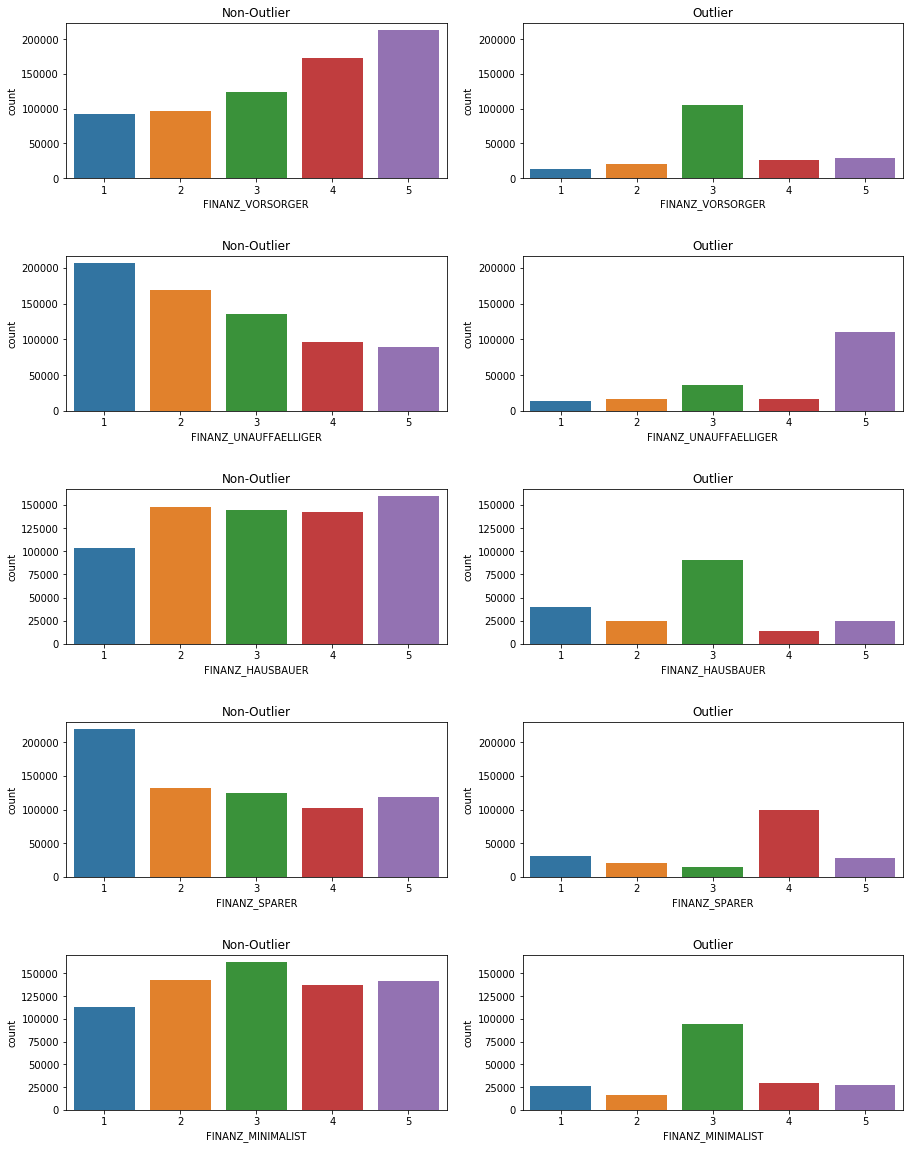

In [147]:
#Separately analyze the FINANZ_ variables:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

# FINANZ_VORSORGER
ax1 = plt.subplot(5, 2, 1)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZ_VORSORGER'])
#sns.barplot(x=df_keeprows['FINANZ_VORSORGER'], y='Counter', data=df_keeprows, estimator=lambda x: sum(x==0)*100.0/len(x))

ax2 = plt.subplot(5, 2, 2, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZ_VORSORGER'])
#sns.barplot(x=df_droprows['FINANZ_VORSORGER'], y='Counter', data=df_keeprows, estimator=lambda x: sum(x==0)*100.0/len(x))

# FINANZ_UNAUFFAELLIGER
ax1 = plt.subplot(5, 2, 3)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZ_UNAUFFAELLIGER'])
ax2 = plt.subplot(5, 2, 4, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZ_UNAUFFAELLIGER'])


# FINANZ_HAUSBAUER
ax1 = plt.subplot(5, 2, 5)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZ_HAUSBAUER'])
ax2 = plt.subplot(5, 2, 6, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZ_HAUSBAUER'])


# FINANZ_SPARER
ax1 = plt.subplot(5, 2, 7)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZ_SPARER'])
ax2 = plt.subplot(5, 2, 8, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZ_SPARER'])


# FINANZ_MINIMALIST
ax1 = plt.subplot(5, 2, 9)
plt.title('Non-Outlier')
sns.countplot(x=df_keeprows['FINANZ_MINIMALIST'])
ax2 = plt.subplot(5, 2, 10, sharey=ax1)
plt.title('Outlier')
sns.countplot(x=df_droprows['FINANZ_MINIMALIST'])

plt.show()

In [148]:
#go ahead and remove rows with too many missing fields:
azdias_droppedrows = df_keeprows

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

In the above cells I compared the value distributions of ten columns with no missing data for the Outlier and Non-Outlier poplulations.  I identify "outlier" as any rows with a number of missing fields exceeding 1.5 times the inter-quartile range of missing fields across rows in the entire dataset.

My findings are as follows:

FINANZTYP - 4 (VORSORGER - be prepared) is overrepresented and 6 is underrepresented in Outlier population

FINANZ_VORSORGER - 3 is overrepresented in outlier population\.

FINANZ_UNAUFFAELLIGER - 3 is overrepresented in outlier population

FINANZ_SPARER - 4 is overrepresented in outlier population

FINANZ_MINIMALIST - 3 is disproportionately high in outlier population.

For simplicity, due to these striking differences in these value distributions, I am going to remove these outlier rows from the dataset I will analyze.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [149]:
# How many features are there of each data type?
feat_info_raw['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [150]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cat_bin = list(feat_info_raw[feat_info_raw['type'] == 'categorical']['attribute'])

feat_bin = []
feat_cat = []

for f in feat_cat_bin:
    try:
        s = list(azdias_droppedrows[f].unique())
        if len([i for i in s if str(i) != 'nan']) == 2:
            feat_bin.append(f)
        else:
            feat_cat.append(f)
    except:
        continue

In [151]:
feat_bin
for f in feat_cat:
    print(f)

CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [152]:
azdias_droppedrows['OST_WEST_KZ - clean'] = azdias_droppedrows['OST_WEST_KZ'].map({'W': 1.0,
                                                                                   'O': 2.0})

azdias_droppedrows['OST_WEST_KZ'] = azdias_droppedrows['OST_WEST_KZ - clean']

azdias_droppedrows = azdias_droppedrows.drop('OST_WEST_KZ - clean', axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [153]:
#Drop categorical features to simplify the analysis
azdias_droppedcat = azdias_droppedrows.drop(feat_cat, axis = 1)

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For simplicity I elected to drop multi-level categorical variables from my analysis. 

I kept all binary variables. I used the map method to fix the values in 'OST_WEST_KZ'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [154]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
"""
From data dict:
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
    """
dict_movement = {  
        -1.: np.nan,
        0.: np.nan,
        1: 1.,
        2: 0.,
        3: 1.,
        4: 0.,
        5: 1.,
        6: 0.,
        7: 0.,
        8: 1.,
        9: 0.,
        10: 1.,
        11: 0.,
        12: 1.,
        13: 0.,
        14: 1.,
        15:  0.
}
dict_generation = {
    
    -1.: np.nan,
    0.: np.nan,
    1: 4.,
    2: 4.,
    3: 5.,
    4: 5.,
    5: 6.,
    6: 6.,
    7: 6.,
    8: 7.,
    9: 7.,
    10: 8.,
    11: 8.,
    12: 8.,
    13: 8.,
    14: 9.,
    15: 9.
}


azdias_droppedcat['Movement'] = azdias_droppedcat['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)
azdias_droppedcat['Generation'] = azdias_droppedcat['PRAEGENDE_JUGENDJAHRE'].map(dict_generation)

In [156]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def parse_cameo(row,place):
    if str(row['CAMEO_INTL_2015']) == 'nan':
        return np.nan
    else:
        return int(row['CAMEO_INTL_2015'][place])

azdias_droppedcat['Wealth'] = azdias_droppedcat.apply(lambda row: parse_cameo(row,0), axis = 1)
azdias_droppedcat['Life Stage'] = azdias_droppedcat.apply(lambda row: parse_cameo(row,1), axis = 1)

In [157]:
#Drop original columns
dropcols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
azdias_droppedcat = azdias_droppedcat.drop(dropcols, axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Using the available 'PRAEGENDE_JUGENDJAHRE' column I first created a "Movement" variable by taking the information from the data dictionary and mapping the corresponding existing values in 'PRAEGENDE_JUGENDJAHRE' to 1 for mainstream and 0 for avantgarde.

Next, I created an ordinal "Generation" column where I imputed an integer for each decade, e.g. 4 for 40s, 5 for 50s.

Separately, I parsed the 'CAMEO_INTL_2015' column by turning the number into a string and then taking the leftmost digit for a new "Wealth" variable and the rightmost digit for a new "Life Stage" variable.

Finally, before proceeding to feature selection, I dropped the original problematic columns.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [158]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
for col in azdias_droppedcat.columns:
    print(col, azdias_droppedcat[col].unique()) 

ALTERSKATEGORIE_GROB [  1.   3.   2.   4.  nan]
ANREDE_KZ [2 1]
FINANZ_MINIMALIST [1 4 3 2 5]
FINANZ_SPARER [5 4 3 1 2]
FINANZ_VORSORGER [2 1 4 5 3]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [4 3 2 5 1]
FINANZ_HAUSBAUER [5 2 3 4 1]
GREEN_AVANTGARDE [0 1]
HEALTH_TYP [  3.   2.   1.  nan]
LP_LEBENSPHASE_FEIN [ 21.   3.  32.   8.   2.   5.  10.   4.   6.  20.   1.  25.  13.  18.  31.
  38.  30.   7.  22.  14.  35.  29.  24.  37.  26.  12.  39.  27.  36.   9.
  34.  33.  15.  11.  40.  16.  19.  23.  28.  17.  nan]
LP_LEBENSPHASE_GROB [  6.   1.  10.   2.   3.   5.   7.  12.   9.   4.  11.   8.  nan]
RETOURTYP_BK_S [ 1.  3.  5.  4.  2.]
SEMIO_SOZ [5 4 6 2 7 1 3]
SEMIO_FAM [4 1 5 7 2 6 3]
SEMIO_REL [4 3 7 5 1 6 2]
SEMIO_MAT [3 2 4 7 5 1 6]
SEMIO_VERT [1 4 7 2 6 5 3]
SEMIO_LUST [2 4 6 3 1 7 5]
SEMIO_ERL [2 6 4 5 7 3 1]
SEMIO_KULT [3 6 5 7 1 4 2]
SEMIO_RAT [6 4 2 7 5 3 1]
SEMIO_KRIT [4 7 3 1 5 2 6]
SEMIO_DOM [7 2 4 1 5 6 3]
SEMIO_KAEM [4 7 2 3 5 6 1]
SEMIO_PFLICHT [7 3 4 5 1 6 2]
SEMIO

In [159]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#everything has been done.
azdias_out = azdias_droppedcat



In [160]:
print("Number of azdias rows: " + str(len(azdias_out)))
print("Number of azdias columns: " + str(len(azdias_out.columns)))

print("Number of azdias rows: " + str(len(feat_info_raw)))
print("Number of feat_info columns: " + str(len(feat_info_raw.columns)))

Number of azdias rows: 697109
Number of azdias columns: 69
Number of azdias rows: 85
Number of feat_info columns: 5


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [163]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i, series in enumerate(df.iteritems()):
        missing_unknown = feat_info_raw['missing_unk_list'][i]
        col = series[0]
        if missing_unknown != ['']:
            queue = []
            for j in missing_unknown:
                if j in ['X','XX']:
                    queue.append(j)
                else:
                    queue.append(int(j))
            df[col] = df[col].replace(queue,np.nan)
    
    print("Nans added")
    
    # remove selected columns and rows, ...
    dropcols = [
    #columns with too many missing values - this is a heuristic based on EDA... want kept columns to be consistent:
        'AGER_TYP',
         'GEBURTSJAHR',
         'TITEL_KZ',
         'ALTER_HH',
         'KK_KUNDENTYP',
         'KBA05_BAUMAX',

        ]
    df1 = df.drop(dropcols, axis = 1)
    
    print("Cols dropped")
    missingrows = df1.isnull().sum(axis = 1)
    missingrows_q25 = missingrows.quantile(0.25)
    missingrows_q75 = missingrows.quantile(0.75)

    missingrows_iqr = missingrows_q75 - missingrows_q25
    
    df1['Number of Missing Fields'] = df1.isnull().sum(axis = 1)

    df2 = df1[df1['Number of Missing Fields'] <= 1.5 * missingrows_iqr].reset_index(drop = True)
    
    print("Rows dropped")
    
    #remove multi-level categorical columns:
    multicatcols = [
        'CJT_GESAMTTYP',
        'FINANZTYP',
        'GFK_URLAUBERTYP',
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'SHOPPER_TYP',
        'ZABEOTYP',
        'GEBAEUDETYP',
        'CAMEO_DEUG_2015',
        'CAMEO_DEU_2015'
    ]
    df2 = df2.drop(multicatcols, axis = 1)
    
    # select, re-encode, and engineer column values.
    
    
    df2['OST_WEST_KZ - clean'] = df2['OST_WEST_KZ'].map({'W': 1.0,
                                                           'O': 2.0})
    
    df2['OST_WEST_KZ'] = df2['OST_WEST_KZ - clean']

    df2 = df2.drop('OST_WEST_KZ - clean', axis = 1)


    dict_movement = {  
            -1.: np.nan,
            0.: np.nan,
            1: 1.,
            2: 0.,
            3: 1.,
            4: 0.,
            5: 1.,
            6: 0.,
            7: 0.,
            8: 1.,
            9: 0.,
            10: 1.,
            11: 0.,
            12: 1.,
            13: 0.,
            14: 1.,
            15:  0.
    }
    dict_generation = {

        -1.: np.nan,
        0.: np.nan,
        1: 4.,
        2: 4.,
        3: 5.,
        4: 5.,
        5: 6.,
        6: 6.,
        7: 6.,
        8: 7.,
        9: 7.,
        10: 8.,
        11: 8.,
        12: 8.,
        13: 8.,
        14: 9.,
        15: 9.
    }


    df2['Movement'] = df2['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)
    df2['Generation'] = df2['PRAEGENDE_JUGENDJAHRE'].map(dict_generation)
    
    print("Movement and Generation reencoded")
    
    
    def parse_cameo(row,place):
        if str(row['CAMEO_INTL_2015']) == 'nan':
            return np.nan
        else:
            return int(row['CAMEO_INTL_2015'][place])
    list_wealth = []
    list_lifestage = []
    
    for row in range(len(df2)):
        if str(df2['CAMEO_INTL_2015'][row]) == 'nan':
            list_wealth.append(np.nan)
            list_lifestage.append(np.nan)
        else:
            list_wealth.append(int(df2['CAMEO_INTL_2015'][row][0]))
            list_lifestage.append(int(df2['CAMEO_INTL_2015'][row][1]))
    
        
    df2['Wealth'] = list_wealth
    df2['Life Stage'] = list_lifestage
    
    dropcols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df3 = df2.drop(dropcols, axis = 1)

    
    print("Cameo parsed")
    print("Cleaning complete.")
    
    print("Number of rows: " + str(len(df3)))
    print("Number of columns: " + str(len(df3.columns)))
    
    # Return the cleaned dataframe.
    return df3

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [164]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_clean = clean_data(azdias_raw)


Nans added
Cols dropped
Rows dropped
Movement and Generation reencoded
Cameo parsed
Cleaning complete.
Number of rows: 697109
Number of columns: 69


In [165]:
impute = Imputer(strategy = 'mean')

df_clean_imputed = pd.DataFrame(impute.fit_transform(df_clean))
df_clean_imputed.columns = df_clean.columns

In [166]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_clean_imp_scaled = pd.DataFrame(scaler.fit_transform(df_clean_imputed), columns = df_clean_imputed.columns)

In [167]:
df_clean_imp_scaled.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Number of Missing Fields,Movement,Generation,Wealth,Life Stage
0,-1.740387,0.969688,-1.522118,1.586768,-1.051497,1.515221,1.047789,1.338667,-0.541398,1.048277,...,1.431222,0.566784,-0.185830,-0.139645,0.675916,-0.314408,0.547614,1.161556,1.173395,-1.261100
1,0.202361,0.969688,-1.522118,0.906946,-1.772674,-0.546081,0.320028,1.338667,1.847069,1.048277,...,0.400940,0.566784,-0.185830,-0.139645,-0.802590,-0.314408,-1.844361,1.161556,-0.875229,0.753395
2,0.202361,-1.031260,0.680524,0.227123,0.390857,-1.233182,0.320028,-0.838345,-0.541398,1.048277,...,-0.629342,-0.332631,0.822105,0.296211,1.415170,-0.314408,0.547614,-0.222116,0.490520,0.081897
3,-1.740387,0.969688,-0.053690,-1.132523,1.112035,-0.546081,-0.407733,1.338667,-0.541398,1.048277,...,1.431222,1.466200,-1.193766,-1.011357,-0.063337,-0.314408,0.547614,-1.605789,1.173395,0.753395
4,-0.769013,0.969688,-1.522118,1.586768,-1.772674,1.515221,1.047789,-0.112675,-0.541398,-0.288183,...,1.431222,1.466200,0.822105,0.296211,-0.063337,-0.314408,0.547614,0.469720,-0.875229,-0.589601


### Discussion 2.1: Apply Feature Scaling

Replaced all missing values with the mean of each column, then scaled all features using sklearn's StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [168]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_clean_imp_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

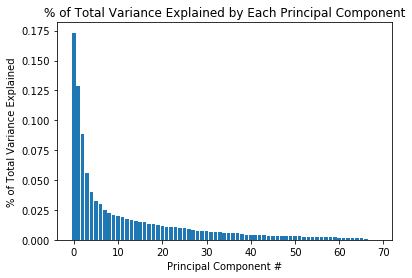

In [169]:
# Investigate the variance accounted for by each principal component.
x = range(len(pca.explained_variance_ratio_))
y = pca.explained_variance_ratio_
plt.bar(x, y)
plt.title('% of Total Variance Explained by Each Principal Component')
plt.xlabel('Principal Component #')
plt.ylabel('% of Total Variance Explained')
plt.show()

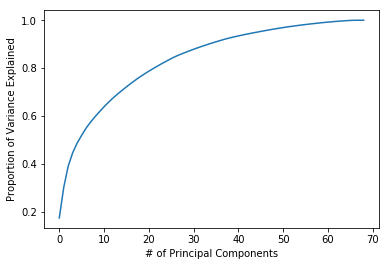

In [172]:
#Make a running sum of the explained variance ratio based on principal components to get an idea of how many to use
x = range(len(pca.explained_variance_ratio_))
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(x,y)
plt.xlabel('# of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [173]:
for i in range(len(x)):
    print(x[i],y[i])    

0 0.173271752306
1 0.301948011081
2 0.390504969899
3 0.446247175372
4 0.486578251371
5 0.51887817422
6 0.549041812521
7 0.57429885949
8 0.596844817583
9 0.617905848781
10 0.63812542991
11 0.65712057874
12 0.674738936618
13 0.690975372714
14 0.706328263717
15 0.721439699522
16 0.73592989726
17 0.749563746559
18 0.762888549465
19 0.775089187457
20 0.786929705367
21 0.798049417184
22 0.808931909743
23 0.819527223505
24 0.82963045622
25 0.839702122587
26 0.848728786157
27 0.856849992659
28 0.864178593826
29 0.871470157426
30 0.878506940026
31 0.885233244884
32 0.891787323403
33 0.897936550684
34 0.904039388813
35 0.909775959889
36 0.915427979225
37 0.920869065635
38 0.925850680264
39 0.930276436084
40 0.934438925904
41 0.938458607288
42 0.942336986285
43 0.946051873238
44 0.949630252824
45 0.953172959989
46 0.956614899648
47 0.959997819138
48 0.96325870564
49 0.96635204048
50 0.96927817479
51 0.97215827782
52 0.974823342099
53 0.977324628315
54 0.979766335576
55 0.982046210964
56 0.9843016

In [170]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components=30)
df_pca = pca_30.fit_transform(df_clean_imp_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I decided to retain 30 principal components.  This amounts to less than half of the number of features I retained after cleaning and still explains almost 88% of the variance in the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [176]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pcaobj, weightnum):
    df = pd.DataFrame(pcaobj.components_, columns = df_clean_imp_scaled.columns)
    weights = df.iloc[weightnum].sort_values(ascending = False)
    return weights


In [177]:
weight_0 = map_weights(pca_30, 0)
print(weight_0)

PLZ8_ANTG3                  0.222003
PLZ8_ANTG4                  0.216230
PLZ8_BAUMAX                 0.212046
Wealth                      0.199487
HH_EINKOMMEN_SCORE          0.195703
ORTSGR_KLS9                 0.194084
EWDICHTE                    0.191409
FINANZ_HAUSBAUER            0.158829
KBA05_ANTG4                 0.150233
PLZ8_ANTG2                  0.149416
ARBEIT                      0.140138
ANZ_HAUSHALTE_AKTIV         0.133642
KBA05_ANTG3                 0.132472
RELAT_AB                    0.130295
FINANZ_SPARER               0.118090
Movement                    0.105252
SEMIO_PFLICHT               0.087799
SEMIO_REL                   0.084379
Generation                  0.079158
SEMIO_RAT                   0.074147
SEMIO_TRADV                 0.070787
REGIOTYP                    0.067873
SEMIO_MAT                   0.066891
SEMIO_FAM                   0.063716
OST_WEST_KZ                 0.056009
SEMIO_KULT                  0.054849
FINANZ_UNAUFFAELLIGER       0.054592
W

In [185]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_1 = map_weights(pca_30, 1)
weight_1

ALTERSKATEGORIE_GROB     0.267466
FINANZ_VORSORGER         0.239295
SEMIO_ERL                0.235510
SEMIO_LUST               0.188503
RETOURTYP_BK_S           0.166525
W_KEIT_KIND_HH           0.117624
SEMIO_KRIT               0.117232
SEMIO_KAEM               0.104024
FINANZ_HAUSBAUER         0.098158
FINANZ_MINIMALIST        0.088712
ANREDE_KZ                0.086060
EWDICHTE                 0.072110
ORTSGR_KLS9              0.070975
PLZ8_ANTG3               0.070402
PLZ8_ANTG4               0.067221
WOHNDAUER_2008           0.064194
SEMIO_DOM                0.063082
PLZ8_BAUMAX              0.062256
KBA05_ANTG4              0.052769
ARBEIT                   0.051478
RELAT_AB                 0.049786
Wealth                   0.049738
PLZ8_ANTG2               0.047993
ANZ_HAUSHALTE_AKTIV      0.045753
KBA05_ANTG3              0.030511
HH_EINKOMMEN_SCORE       0.029143
VERS_TYP                 0.027800
ANZ_HH_TITEL             0.026545
OST_WEST_KZ              0.020015
Life Stage    

In [186]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_2 = map_weights(pca_30, 2)
weight_2

SEMIO_VERT                  0.348394
SEMIO_SOZ                   0.264071
SEMIO_FAM                   0.250993
SEMIO_KULT                  0.232685
FINANZ_MINIMALIST           0.162438
RETOURTYP_BK_S              0.113909
FINANZ_VORSORGER            0.097982
W_KEIT_KIND_HH              0.087945
ALTERSKATEGORIE_GROB        0.080673
SEMIO_REL                   0.078075
SEMIO_LUST                  0.070142
GREEN_AVANTGARDE            0.056827
SEMIO_MAT                   0.052939
ORTSGR_KLS9                 0.044064
EWDICHTE                    0.043900
PLZ8_BAUMAX                 0.042900
PLZ8_ANTG4                  0.040542
PLZ8_ANTG3                  0.039434
WOHNDAUER_2008              0.036569
ARBEIT                      0.028906
RELAT_AB                    0.027678
PLZ8_ANTG2                  0.026372
KBA05_ANTG4                 0.023012
ANZ_HAUSHALTE_AKTIV         0.021033
VERS_TYP                    0.020867
Wealth                      0.017692
ANZ_HH_TITEL                0.013088
A

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


Based on the first principal component...

PLZ8_ANTG3 and PLZ8_ANTG4 are positively correlated.  Looking at the data dictionary, this makes sense because these variables respectively represent the number of 6-10 and 10+ family households in the PLZ8 region.  That region must be a densely populated area.

PLZ8_ANTG3 and MOBI_REGIO are negatively correlated.  This makes sense because large families are intuitively less likely to have heavy movement patterns.

It makes sense that we see PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX (ordinal; the most common building type in the PLZ8 region), and Wealth are positively correlated and influence the data in a similar way.  Intuitively it makes sense that wealthier areas will have higher frequencies of large/luxurious homes and larger families.  It is evidenty that the first principal component measures some combination of household size and wealth.

Second PC:


Top Positive:


ALTERSKATEGORIE_GROB     0.267466 - estimated age based on given name analysis
FINANZ_VORSORGER         0.239295 - financial preparedness
SEMIO_ERL                0.235510 - event-oriented personality
SEMIO_LUST               0.188503 - sensual minded personality

Top Negative:


SEMIO_PFLICHT           -0.241005 - dutiful
FINANZ_SPARER           -0.249216 - money-saver
Generation              -0.256458 - negative correlation means this corresponds to older people (lower values)
SEMIO_REL               -0.267407 - religious


For the second PC it seems like this is a measurement of finacial/lifestyle conservatism.  Traits such as frugality and religiousness appear on one end, while traits such as sensuality and event-orientedness.


Third PC:


Top Positive:


SEMIO_VERT                  0.348394 - dreamful
SEMIO_SOZ                   0.264071 - socially-minded
SEMIO_FAM                   0.250993 - family-minded
SEMIO_KULT                  0.232685 - cultural-minded

Top Negative:


SEMIO_KRIT                 -0.271108 - critical-minded
SEMIO_DOM                  -0.311968 - dominant-minded
SEMIO_KAEM                 -0.338274 - combative attitude
ANREDE_KZ                  -0.368936 - negative correlation means males are predominant because value of 1 for male versus 2 for female


This third component seems to be a measurement of agreeableness.  On one end tend to be individuals who are socially and family oriented and probably relatively conscientiousness.  On the other end it is clear that there predominantly left-brained, disagreeable individuals, and it appears that this is predominantly male. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [180]:
def score_kmeans(data, n_clusters):
    model = KMeans(n_clusters = n_clusters)
    model = model.fit(data)
    return np.abs(model.score(data))


In [181]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []

for i in list(range(1,21)):
    scores.append(score_kmeans(df_clean_imp_scaled, i))
    print("Scoring complete for k = " + str(i))

Scoring complete for k = 1
Scoring complete for k = 2
Scoring complete for k = 3
Scoring complete for k = 4
Scoring complete for k = 5
Scoring complete for k = 6
Scoring complete for k = 7
Scoring complete for k = 8
Scoring complete for k = 9
Scoring complete for k = 10
Scoring complete for k = 11
Scoring complete for k = 12
Scoring complete for k = 13
Scoring complete for k = 14
Scoring complete for k = 15
Scoring complete for k = 16
Scoring complete for k = 17
Scoring complete for k = 18
Scoring complete for k = 19
Scoring complete for k = 20


In [182]:
scores

[48100520.999999993,
 41825190.847992025,
 38840998.426954918,
 36947352.168144323,
 35644819.414659232,
 34496455.957203627,
 33495273.697204567,
 32707566.481981564,
 32094612.894245602,
 31548834.070596155,
 31131684.015835349,
 30486418.280517198,
 30102345.821040802,
 29835223.586716987,
 29223370.118372384,
 29055698.374279793,
 29112422.471604086,
 28574536.781424459,
 28357370.180095192,
 28462329.144164301]

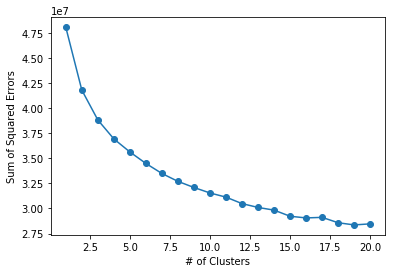

In [183]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(list(range(1,21)), scores, linestyle = '-', marker = 'o')
plt.xlabel('# of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()

In [187]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#13 clusters looks like the elbow.

kmeans = KMeans(n_clusters = 13)
kmeans_13 = kmeans.fit(df_pca)
kmeans_pred = kmeans_13.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Looks like k=13 is the elbow point, so we will go with k = 13.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [188]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [189]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers_clean = clean_data(customers)

Nans added
Cols dropped
Rows dropped
Movement and Generation reencoded
Cameo parsed
Cleaning complete.
Number of rows: 191652
Number of columns: 69


In [190]:
df_customers_clean_imp = pd.DataFrame(impute.fit_transform(df_customers_clean))
df_customers_clean_imp.columns = df_customers_clean.columns

In [191]:
df_customers_clean_imp_scaled = pd.DataFrame(scaler.transform(df_customers_clean_imp), columns = df_customers_clean_imp.columns)

In [192]:
df_customers_pca = pca_30.transform(df_customers_clean_imp_scaled)
df_customers_pred = kmeans_13.predict(df_customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer Clusters')

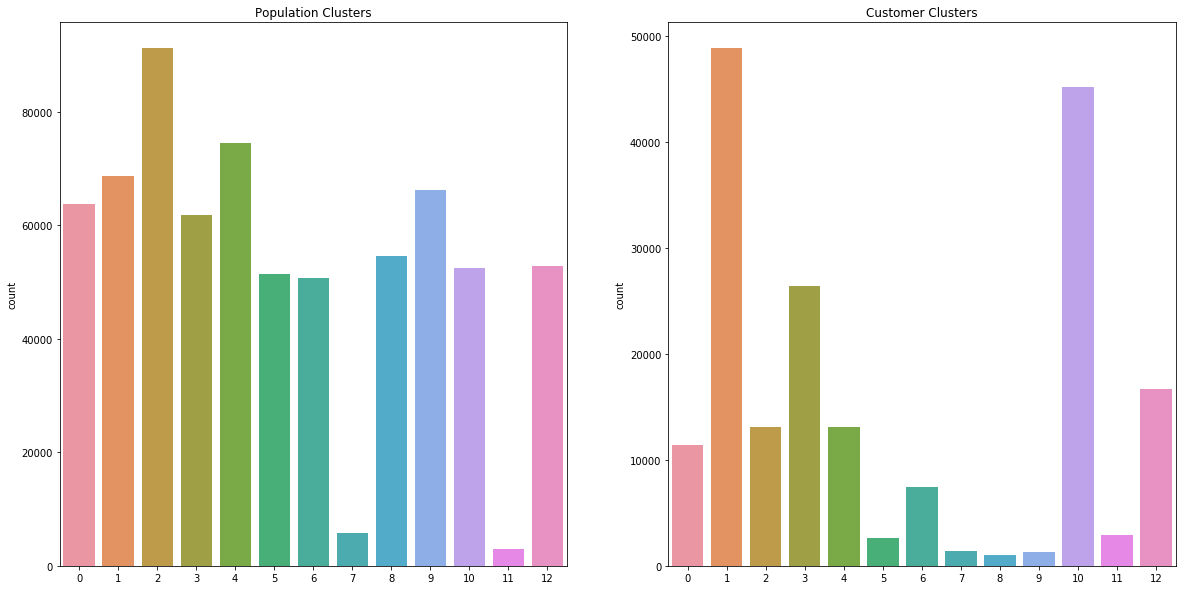

In [197]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
figure.subplots_adjust(hspace = .5)

#General Population
sns.countplot(kmeans_pred, ax = ax[0])
ax[0].set_title('Population Clusters')
#Customer Subset
sns.countplot(df_customers_pred, ax = ax[1])
ax[1].set_title('Customer Clusters')

In [202]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_10 = scaler.inverse_transform(pca_30.inverse_transform(kmeans_13.cluster_centers_[10]))
df_overrepresented = pd.Series(data = cluster_10, index = df_customers_clean_imp_scaled.columns)
print(df_overrepresented)

ALTERSKATEGORIE_GROB          3.301835
ANREDE_KZ                     1.048944
FINANZ_MINIMALIST             4.834402
FINANZ_SPARER                 1.620587
FINANZ_VORSORGER              4.195304
FINANZ_ANLEGER                1.466932
FINANZ_UNAUFFAELLIGER         2.145355
FINANZ_HAUSBAUER              1.910377
GREEN_AVANTGARDE              0.961769
HEALTH_TYP                    2.072842
LP_LEBENSPHASE_FEIN          25.043424
LP_LEBENSPHASE_GROB           7.287322
RETOURTYP_BK_S                3.946849
SEMIO_SOZ                     4.927638
SEMIO_FAM                     4.824050
SEMIO_REL                     3.768831
SEMIO_MAT                     3.925741
SEMIO_VERT                    6.202619
SEMIO_LUST                    5.265474
SEMIO_ERL                     4.093673
SEMIO_KULT                    4.920150
SEMIO_RAT                     2.702951
SEMIO_KRIT                    3.119011
SEMIO_DOM                     3.411354
SEMIO_KAEM                    2.626265
SEMIO_PFLICHT            

In [195]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_9 = scaler.inverse_transform(pca_30.inverse_transform(kmeans_13.cluster_centers_[9]))
df_underrepresented = pd.Series(data = cluster_9, index = df_customers_clean_imp_scaled.columns)
df_underrepresented

ALTERSKATEGORIE_GROB          1.555728
ANREDE_KZ                     2.020791
FINANZ_MINIMALIST             1.178414
FINANZ_SPARER                 4.224276
FINANZ_VORSORGER              2.197455
FINANZ_ANLEGER                4.079960
FINANZ_UNAUFFAELLIGER         3.616081
FINANZ_HAUSBAUER              4.184341
GREEN_AVANTGARDE              0.039782
HEALTH_TYP                    2.190787
LP_LEBENSPHASE_FEIN           9.832695
LP_LEBENSPHASE_GROB           3.284089
RETOURTYP_BK_S                2.411168
SEMIO_SOZ                     3.236154
SEMIO_FAM                     3.906741
SEMIO_REL                     5.327618
SEMIO_MAT                     5.108449
SEMIO_VERT                    2.220801
SEMIO_LUST                    2.683616
SEMIO_ERL                     4.177070
SEMIO_KULT                    4.178180
SEMIO_RAT                     6.337766
SEMIO_KRIT                    5.550917
SEMIO_DOM                     6.272187
SEMIO_KAEM                    6.207739
SEMIO_PFLICHT            

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Cluster 10 is overrepresented in the customer data versus that of the general population.  People who share these characteristics are customers we might want to pursue.  Some characteristics in of this cluster include:


1. Wealth - 2.124293 - these people tend to come from prosperous or wealthy households
2. Life Stage - 3.643751... these people tend to have school age children or be older/more mature couples
3. Generation - 6.592302... these people tend to have been from the 60s generation
4. Movement - 0.036927... these people tend to be part of avantgarde movements (because I encoded 0 for avantgarde for this engineered variable)


Cluster 9 is underrepresented and therefore represents people who are likely less fruitful to pursue.  Some characteristics of this cluster include:


1. Wealth - 4.358496... these people tend to be less affluent
2. Life Stage - 2.063198... these people tend to be young couples with pre-school age children
3. Generation - 8.638969 ... these people tend to have been from the 80s generation
4. Movement - 0.959282 ... these people tend to be part of mainstream movements (because I encoded 1 for mainstream for this engineered variable)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.